In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist

from keras.models import Sequential,Model,model_from_json,load_model
from keras import optimizers
from keras.layers import Input, Dense, BatchNormalization, Embedding
from keras.layers import Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import plot_model

Using TensorFlow backend.


## BatchNormalization

In [2]:
n_data = 1000
n_feature = 4

In [3]:
x1 = Input(shape=(n_feature,))
x2 = BatchNormalization(trainable = True)(x1)

model = Model(inputs=x1,outputs=x2)
model.compile(optimizer = 'sgd', loss = 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
Total params: 16
Trainable params: 8
Non-trainable params: 8
_________________________________________________________________


In [4]:
x = np.zeros((n_data,n_feature))
y = np.zeros((n_data,n_feature))
for i in range(n_feature):
    sample = np.random.normal(0,1,n_data)
    x[:,i] = 4*sample+5
    y[:,i] = (i+1)**2*sample+i

In [5]:
history = model.fit(x, y, batch_size = 100, epochs = 1000, verbose = 0)

In [7]:
for i in model.layers[1].get_weights():
    print('     '.join(n_feature*['{:2.2f}']).format(*i))

1.02     4.12     8.65     15.95
0.01     0.78     2.19     2.55
5.04     4.78     5.09     4.89
17.03     17.22     15.00     16.14


In [8]:
y = model.predict(x)

In [9]:
x = np.mean(y,axis=0)
'     '.join(n_feature*['{:2.2f}']).format(*x)

'0.01     0.79     2.19     2.55'

In [10]:
x = np.std(y,axis=0)
'     '.join(n_feature*['{:2.2f}']).format(*x)

'1.02     4.12     8.65     15.93'

## We need to load a dataset

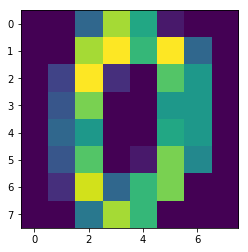

label:  0


In [2]:
data = datasets.load_digits()
plt.imshow(data.images[0])    # show first number in the dataset
plt.show()
print('label: ', data.target[0])    # label = '0'

In [3]:
X_data = data.images
y_data = data.target

# shape of data
print(X_data.shape)    # (8 X 8) format
print(y_data.shape)

(1797, 8, 8)
(1797,)


In [4]:
# reshape X_data into 3-D format
# note that this follows image format of Tensorflow backend
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))

# one-hot encoding of y_data
y_data = to_categorical(y_data)

# partition data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = 777)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1257, 8, 8, 1)
(540, 8, 8, 1)
(1257, 10)
(540, 10)


In [6]:
model = Sequential()

In [7]:
# convolution layer
model.add(Conv2D(input_shape = (X_data.shape[1], X_data.shape[2], X_data.shape[3]), filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2)))

# prior layer should be flattend to be connected to dense layers
model.add(Flatten())

# dense layer with 50 neurons
model.add(Dense(50, activation = 'relu'))

# final layer with 10 neurons to classify the instances
model.add(Dense(10, activation = 'softmax'))

In [8]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [10]:
history = model.fit(X_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 5, verbose = 1)

Train on 1005 samples, validate on 252 samples
Epoch 1/5
1005/1005 [==============================] - 0s 67us/step - loss: 0.3772 - acc: 0.8886 - val_loss: 0.2726 - val_acc: 0.9206
Epoch 2/5
1005/1005 [==============================] - 0s 70us/step - loss: 0.2839 - acc: 0.9264 - val_loss: 0.2341 - val_acc: 0.9365
Epoch 3/5
1005/1005 [==============================] - 0s 60us/step - loss: 0.2295 - acc: 0.9353 - val_loss: 0.1910 - val_acc: 0.9286
Epoch 4/5
1005/1005 [==============================] - 0s 70us/step - loss: 0.1881 - acc: 0.9542 - val_loss: 0.1710 - val_acc: 0.9405
Epoch 5/5
1005/1005 [==============================] - 0s 52us/step - loss: 0.1675 - acc: 0.9582 - val_loss: 0.1498 - val_acc: 0.9484


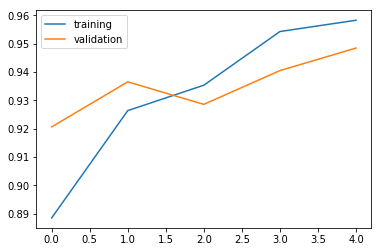

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

## Save and load a model

### Save the weights

In [12]:
model.save_weights('model_weights.h5')

### Save the model architecture

In [13]:
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [5]:
# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

In [7]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [8]:
model.evaluate(X_test, y_test)[1]

540/540 [==============================] - 0s 106us/step


0.9185185194015503

# Entire model

This single HDF5 file will contain:

- the architecture of the model (allowing the recreation of the model)
- the weights of the model
- the training configuration (e.g. loss, optimizer)
- the state of the optimizer (allows you to resume the training from exactly where you left off)

In [9]:
# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
del model  

In [10]:
# Returns a compiled model identical to the previous one
model = load_model('my_model.h5')

In [11]:
model.evaluate(X_test, y_test)[1]

540/540 [==============================] - 0s 131us/step


0.9185185194015503

In [2]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

from data.CIFAR100_labels import labels

In [12]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)

labels = np.arange(10)

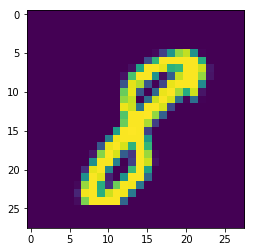

label:  8


In [17]:
ii = np.random.randint(1000)
plt.imshow(x_train[ii,:,:,0])    # show first number in the dataset
plt.show()
print('label: ', labels[int(y_train[ii])])    # label = '0'

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
x_train = x_train[:10000]
x_test = x_test[:1000]
y_train = y_train[:10000]
y_test = y_test[:1000]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(10000, 28, 28, 1) (10000, 10) (1000, 28, 28, 1) (1000, 10)


In [20]:
model = Sequential()

model.add(Conv2D(input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]),
                 filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# prior layer should be flattend to be connected to dense layers
model.add(Flatten())
# dense layer with 50 neurons
model.add(Dense(50, activation = 'relu'))
# final layer with 10 neurons to classify the instances
model.add(Dense(y_train.shape[1], activation = 'softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        14432     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 32)        0         
__________

In [22]:
plot_model(model, to_file='model.png')

In [26]:
history = model.fit(x_train, y_train, batch_size = 50, validation_split = 0.2, epochs = 3, verbose = 1)

In [24]:
plt.plot(history.history['acc'],'red')
plt.plot(history.history['val_acc'],'blue')

### Changing Learning rate after every epoch.

In [30]:
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=1, verbose=0):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        if verbose:
            print('show:',lr)
        return lr
    
    return LearningRateScheduler(schedule,verbose=verbose)

lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, verbose=1)

def schedule(epoch):
    lr = 10e-3 * (0.75 ** np.floor(epoch))
    print('show:',lr)
    return lr
lr_sched = LearningRateScheduler(schedule,verbose=1)

In [31]:
history = model.fit(x_train, y_train,
                    batch_size = 50,
                    validation_split = 0.2,
                    epochs = 3, verbose = 1,
                    callbacks=[lr_sched])

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
show: 0.01

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
8000/8000 [==============================] - 45s 6ms/step - loss: 0.8785 - acc: 0.7422 - val_loss: 0.3371 - val_acc: 0.8965
Epoch 2/3
show: 0.0075

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075.
8000/8000 [==============================] - 45s 6ms/step - loss: 0.2105 - acc: 0.9389 - val_loss: 0.1969 - val_acc: 0.9445
Epoch 3/3
show: 0.005625

Epoch 00003: LearningRateScheduler setting learning rate to 0.005625.
8000/8000 [==============================] - 45s 6ms/step - loss: 0.1283 - acc: 0.9609 - val_loss: 0.1546 - val_acc: 0.9575


### Stop training when a monitored quantity has stopped improving.

In [88]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 10,
                          patience = 1,
                          verbose = 1,
                          restore_best_weights = True)

In [92]:
history = model.fit(x_train, y_train,
                    batch_size = 50,
                    validation_split = 0.2,
                    epochs = 3, verbose = 1,
                    callbacks=[lr_sched,earlystop])

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
show: 0.001

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
8000/8000 [==============================] - 36s 5ms/step - loss: 0.6512 - acc: 0.7939 - val_loss: 0.2643 - val_acc: 0.9200
Epoch 2/3
show: 0.00075

Epoch 00002: LearningRateScheduler setting learning rate to 0.00075.
8000/8000 [==============================] - 34s 4ms/step - loss: 0.1364 - acc: 0.9591 - val_loss: 0.1500 - val_acc: 0.9520
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping


### Save the model after every epoch.

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size = 50,
                    validation_split = 0.2,
                    epochs = 3, verbose = 1,
                    callbacks=[lr_sched,earlystop,checkpoint])

### Callback that terminates training when a NaN loss is encountered.


In [ ]:
from keras.callbacks.callbacks import TerminateOnNaN